# DEA Coastlines vector statistics <img align="right" src="https://github.com/GeoscienceAustralia/dea-notebooks/raw/develop/Supplementary_data/dea_logo.jpg">

This code conducts vector subpixel shoreline extraction for DEA Coastlines:

* Apply morphological extraction algorithms to mask annual median composite rasters to a valid coastal region
* Extract waterline vectors using subpixel waterline extraction ([Bishop-Taylor et al. 2019b](https://doi.org/10.3390/rs11242984))
* Compute rates of coastal change at every 30 m using linear regression

This is an interactive version of the code intended for prototyping; to run this analysis at scale, use the [command line tools](DEACoastlines_generation_CLI.ipynb).


---

## Getting started
Set working directory to top level of repo to ensure links work correctly:

In [1]:
cd ..

/home/jovyan/Robbi/dea-coastlines


### Load packages

First we import the required Python packages, then we connect to the database, and load the catalog of virtual products.

In [3]:
pip install -r requirements.in --quiet

You should consider upgrading via the '/env/bin/python -m pip install --upgrade pip' command.
Note: you may need to restart the kernel to use updated packages.


In [11]:
%matplotlib inline
%load_ext line_profiler
%load_ext autoreload
%autoreload 2

import os
import sys
import odc.geo.xr
import numpy as np
import pandas as pd
import xarray as xr
import geohash as gh
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import box
from dea_tools.spatial import subpixel_contours

# Load DEA Coastlines code
import coastlines.raster
import coastlines.vector

# Hide Pandas warnings
pd.options.mode.chained_assignment = None

## Load in data

In [3]:
study_area = 3
raster_version = 'development'
vector_version = 'development'
water_index = "mndwi"
index_threshold = 0.00
start_year = 1988
end_year = 2021
baseline_year = 2021
# config_path = 'configs/dea_coastlines_config.yaml'
config_path = 'configs/dea_coastlines_config_development.yaml'

# Load analysis params from config file
config = coastlines.raster.load_config(
    config_path=config_path
)

## Load DEA Coastlines rasters

In [4]:
yearly_ds, gapfill_ds = coastlines.vector.load_rasters(
    path="data/interim/raster",
    raster_version=raster_version,
    study_area=study_area,
    water_index=water_index,
    start_year=start_year,
    end_year=end_year,
)
print(yearly_ds)

# Create output vector folder
output_dir = f"data/interim/vector/{vector_version}/{study_area}_{vector_version}"
os.makedirs(output_dir, exist_ok=True)

<xarray.Dataset>
Dimensions:  (year: 34, y: 657, x: 729)
Coordinates:
  * year     (year) int64 1988 1989 1990 1991 1992 ... 2017 2018 2019 2020 2021
  * y        (y) float64 -1.279e+06 -1.279e+06 ... -1.299e+06 -1.299e+06
  * x        (x) float64 2.341e+05 2.341e+05 2.341e+05 ... 2.559e+05 2.559e+05
Data variables:
    mndwi    (year, y, x) float32 0.5658 0.5996 0.7044 ... -0.5677 -0.589 -0.602
    count    (year, y, x) int16 8 8 8 8 8 8 8 8 8 ... 13 13 13 13 12 12 12 12 12
    stdev    (year, y, x) float32 0.1563 0.142 0.1246 ... 0.1127 0.1097 0.1055
Attributes:
    transform:      (30.0, 0.0, 234045.0, 0.0, -30.0, -1278915.0)
    crs:            +init=epsg:32653
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Area


## Load vector data

In [5]:
# Get bounding box to load data for
bbox = gpd.GeoSeries(yearly_ds.odc.geobox.extent.geom, crs=yearly_ds.odc.crs)

# Study area polygon
gridcell_gdf = (
    gpd.read_file(config["Input files"]["grid_path"], bbox=bbox)
    .set_index("id")
    .to_crs(str(yearly_ds.odc.crs))
)
gridcell_gdf.index = gridcell_gdf.index.astype(int).astype(str)
gridcell_gdf = gridcell_gdf.loc[[str(study_area)]]

# # Coastal mask modifications
# modifications_gdf = gpd.read_file(
#     config["Input files"]["modifications_path"], bbox=bbox
# ).to_crs(str(yearly_ds.odc.crs))

# Geomorphology dataset
geomorphology_gdf = gpd.read_file(
    config["Input files"]["geomorphology_path"], bbox=bbox
).to_crs(str(yearly_ds.odc.crs))

# Region attribute dataset
region_gdf = gpd.read_file(
    config["Input files"]["region_attributes_path"], bbox=bbox
).to_crs(str(yearly_ds.odc.crs))

## Extract annual shorelines

### Restrict annual shorelines to coastal study area

In [ ]:
# %load_ext line_profiler

In [ ]:
# %lprun -u 1 -f coastlines.vector.contours_preprocess coastlines.vector.contours_preprocess(yearly_ds, gapfill_ds, water_index, index_threshold, buffer_pixels=33, mask_landcover=False, mask_modifications=None)

In [ ]:
# %lprun -u 1 -f coastlines.vector.coastal_masking coastlines.vector.coastal_masking(ds=all_time, ocean_da=ocean_da, buffer=buffer_pixels, closing=15)

In [ ]:
# %lprun -u 1 -f coastlines.vector.certainty_masking coastlines.vector.certainty_masking(yearly_ds, obs_threshold=5, stdev_threshold=0.25, sieve_size=128)

In [94]:
# Mask dataset to focus on coastal zone only
masked_ds, certainty_masks = coastlines.vector.contours_preprocess(
    yearly_ds,
    gapfill_ds,
    water_index,
    index_threshold,
    buffer_pixels=33,
    mask_modifications=None, # modifications_gdf,
)

In [110]:
# Extract contours
contours_gdf = subpixel_contours(
    da=masked_ds,
    z_values=index_threshold,
    min_vertices=10,
    dim="year",
    output_path=f"temp.geojson",
).set_index("year")

Operating in single z-value, multiple arrays mode
Writing contours to temp.geojson


In [170]:
# DEBUG
(
    masked_ds,
    certainty_masks,
    all_time,
    all_time_clean,
    river_mask,
    ocean_da,
    coastal_mask,
    inland_mask,
    thresholded_ds,
    annual_mask,
) = coastlines.vector.contours_preprocess(
    yearly_ds,
    gapfill_ds,
    water_index,
    index_threshold,
    buffer_pixels=33,
    mask_modifications=None,
    debug=True,
)

In [168]:
# OPTION A
island_size = int(5000000 / (30 * 30))  # 5 km^2
sieved = xr.apply_ufunc(sieve, all_time.astype(np.int16), island_size)
rivers = xr.apply_ufunc(black_tophat, (sieved & all_time), disk(5)) == 1
all_time_clean = all_time.where(~rivers, True)

# OPTION B
rivers = xr.apply_ufunc(black_tophat, all_time, disk(5))
all_time_clean = all_time.where(~rivers, True)

# all_time_clean.odc.assign_crs(yearly_ds.odc.crs).astype(np.int16).odc.write_cog('all_time_clean.tif', overwrite=True)

In [166]:
rivers

<xarray.DataArray 'mndwi' (y: 657, x: 729)>
array([[ True,  True,  True, ..., False, False, False],
       [ True,  True,  True, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])
Coordinates:
  * y        (y) float64 -1.279e+06 -1.279e+06 ... -1.299e+06 -1.299e+06
  * x        (x) float64 2.341e+05 2.341e+05 2.341e+05 ... 2.559e+05 2.559e+05

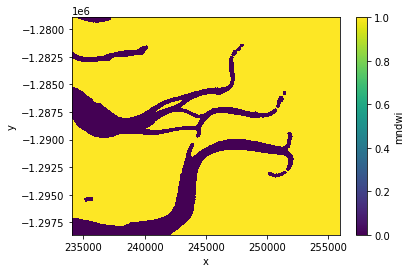

In [169]:
all_time_clean.plot()

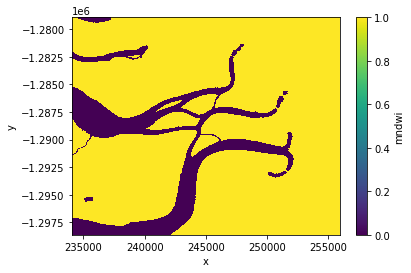

In [167]:
all_time_clean.plot()

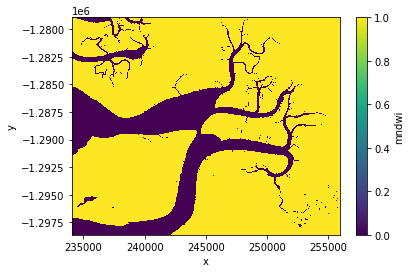

In [161]:
(sieved & all_time).plot()

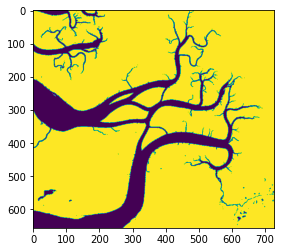

In [154]:
plt.imshow(sieve(all_time.astype(np.int16).values, size=5555, mask=~all_time.values))

In [148]:
xr.apply_ufunc(sieve, all_time.astype(np.int16), kwargs={'size': island_size, 'mask': all_time}).plot(size=10)

TypeError: Argument 'image' has incorrect type (expected numpy.ndarray, got DataArray)

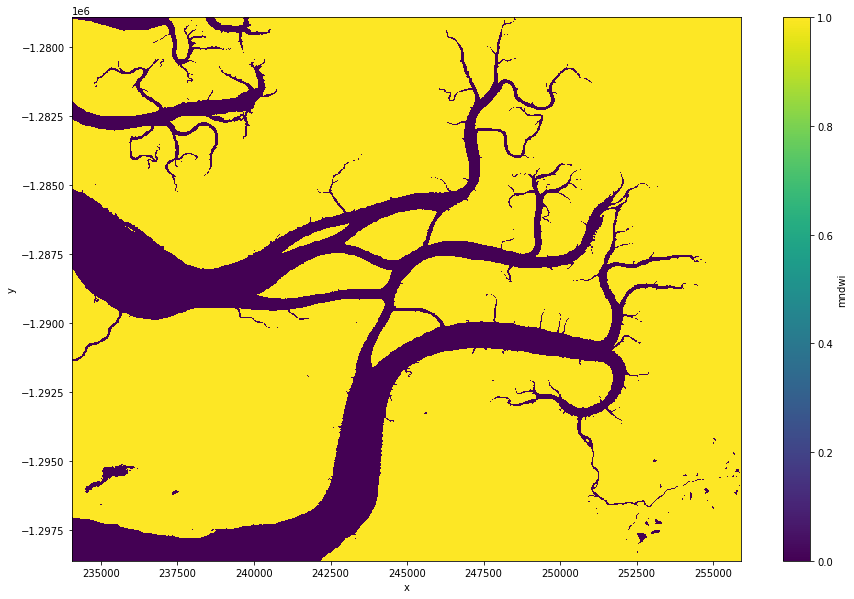

In [137]:
all_time.plot(size=10)

In [125]:
# # Create a river mask by eroding the all time layer to clip out river
# # and estuary mouths, then expanding river features to include stream
# # banks and account for migrating rivers
all_time_eroded = xr.apply_ufunc(binary_erosion, all_time_clean, disk(10))
# rivers = rivers.where(all_time_eroded, False)
# river_mask = ~xr.apply_ufunc(binary_dilation, rivers, disk(5))

In [122]:
all_time_eroded.odc.assign_crs(yearly_ds.odc.crs).astype(np.int16).odc.write_cog('all_time_eroded.tif', overwrite=True)

PosixPath('all_time_eroded.tif')

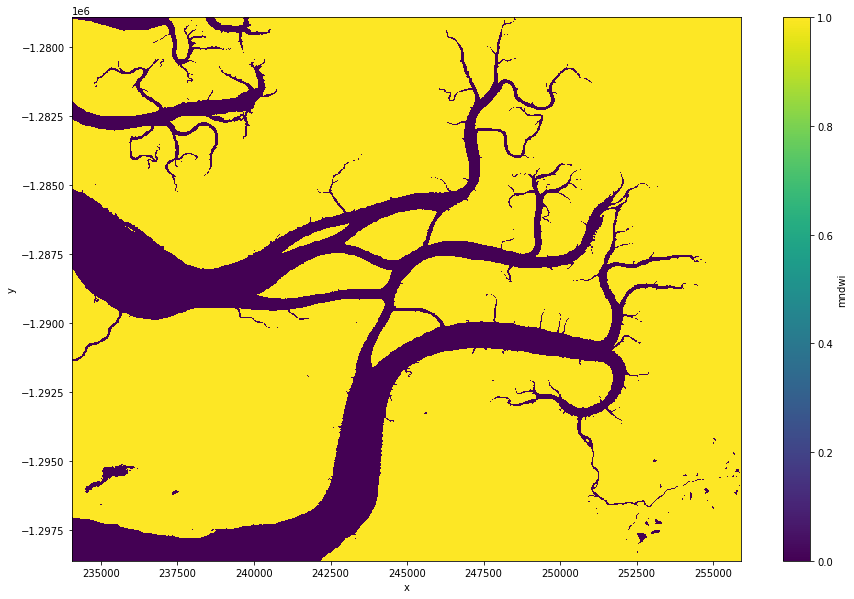

In [123]:
all_time.plot(size=10)

PosixPath('all_time_clean.tif')

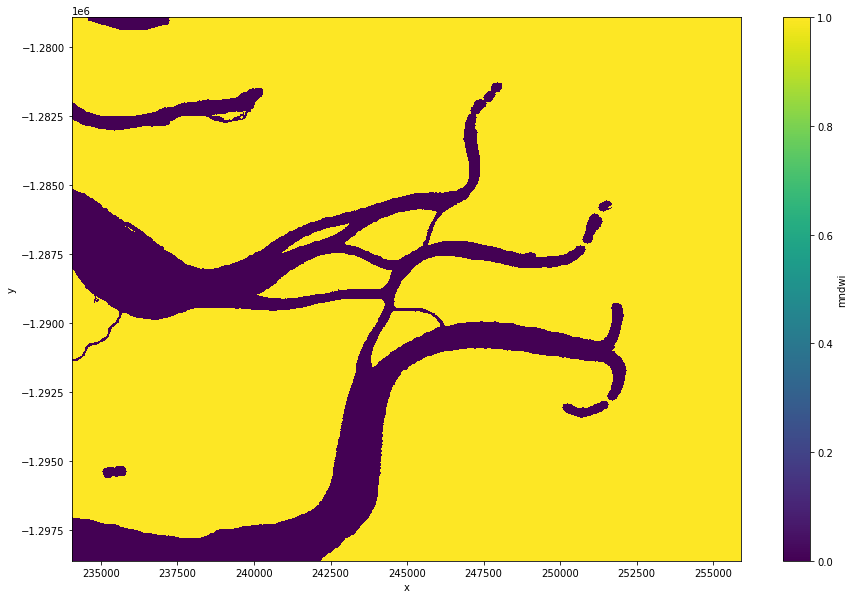

In [171]:
all_time_clean.plot(size=10)
all_time_clean.odc.assign_crs(yearly_ds.odc.crs).astype(np.int16).odc.write_cog('all_time_clean.tif', overwrite=True)

PosixPath('river_mask.tif')

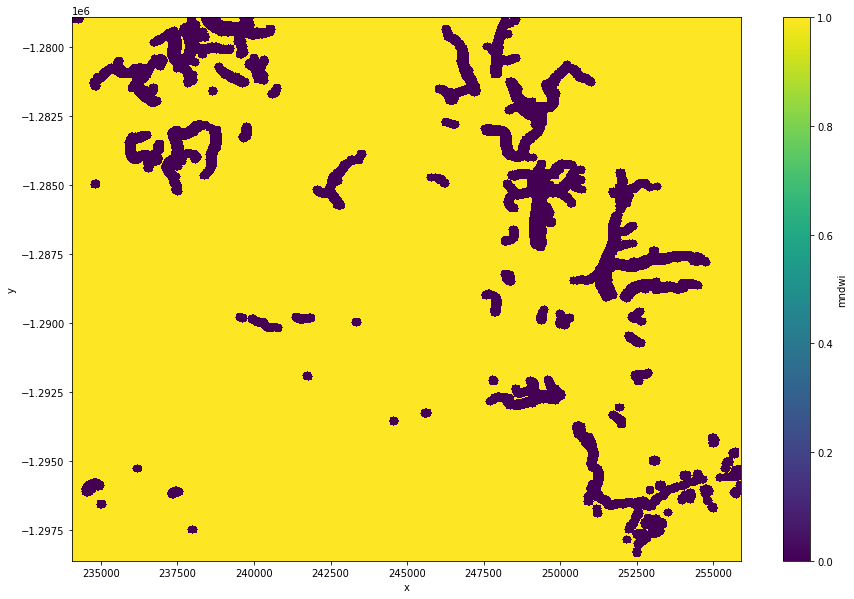

In [172]:
river_mask.plot(size=10)
river_mask.odc.assign_crs(yearly_ds.odc.crs).astype(np.int16).odc.write_cog('river_mask.tif', overwrite=True)

In [15]:
# all_time_eroded = xr.apply_ufunc(binary_erosion, all_time_clean, disk(10))
# all_time_eroded.odc.assign_crs(yearly_ds.odc.crs).astype(np.int16).odc.write_cog('all_time_eroded.tif', overwrite=True)

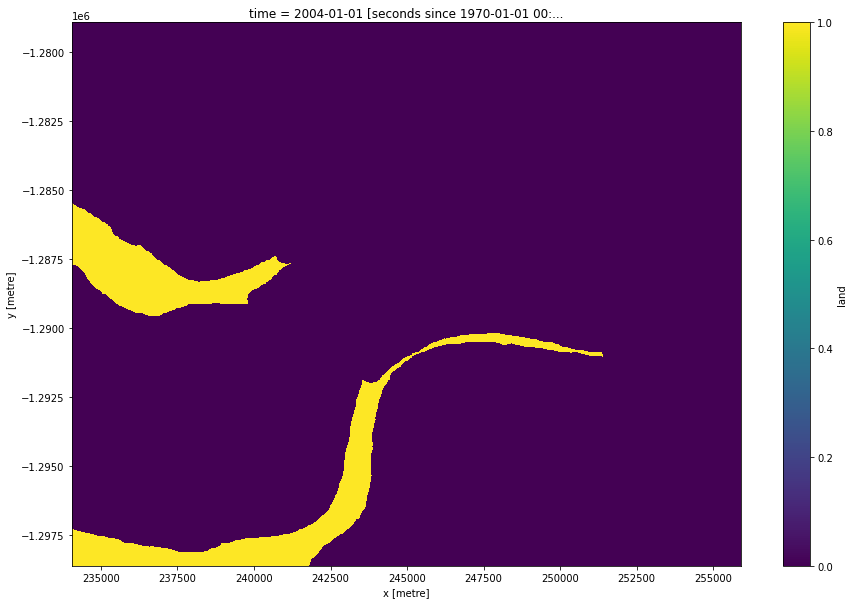

In [173]:
ocean_da.plot(size=10)

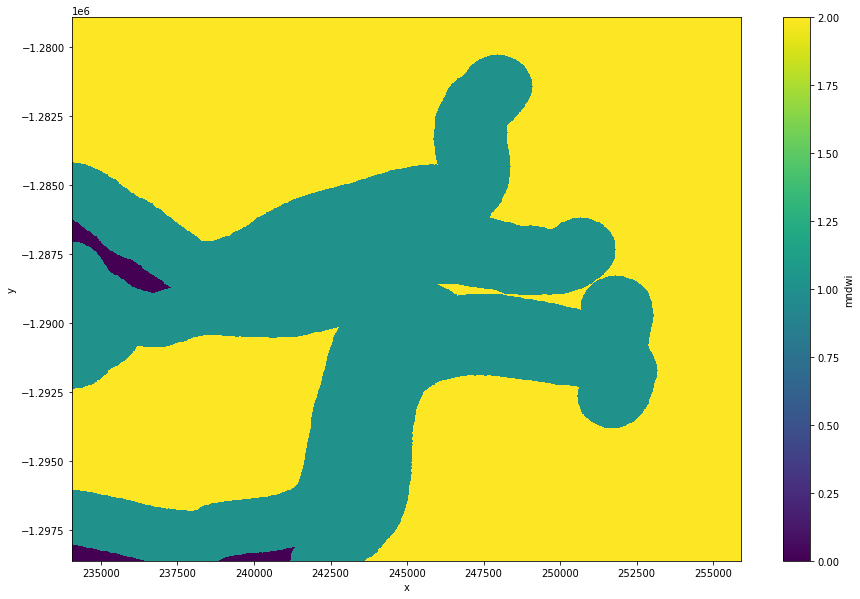

In [174]:
coastal_mask.plot(size=10)

PosixPath('annual_mask_i.tif')

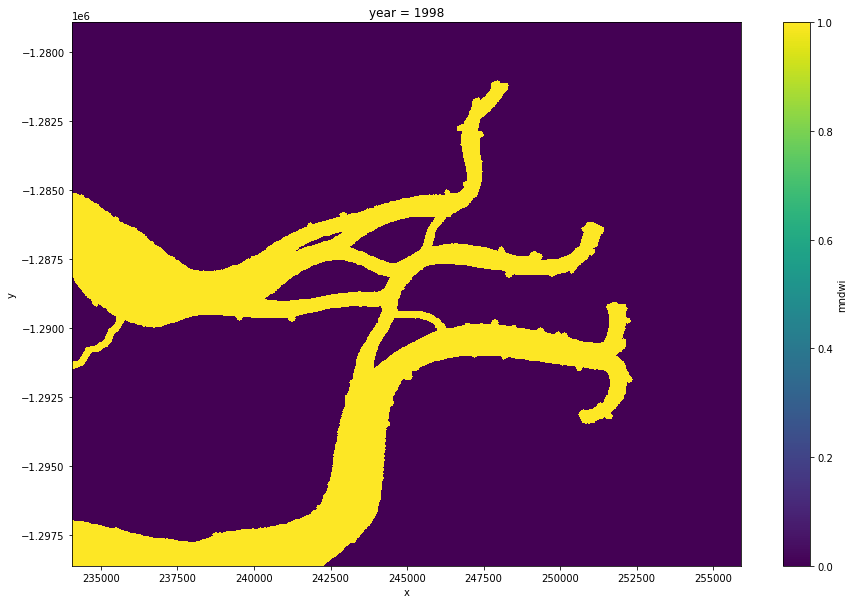

In [175]:
annual_mask.isel(year=10).plot(size=10)
annual_mask.odc.assign_crs(yearly_ds.odc.crs).isel(year=10).astype(np.int16).odc.write_cog('annual_mask_i.tif', overwrite=True)

In [176]:
# Extract contours
contours_gdf = subpixel_contours(
    da=masked_ds,
    z_values=index_threshold,
    min_vertices=10,
    dim="year",
    output_path=f"temp.geojson",
).set_index("year")

# Assign certainty to contours based on underlying masks
contours_gdf = coastlines.vector.contour_certainty(contours_gdf, certainty_masks)

# Add tide datum details (this supports future addition of extra tide datums)
contours_gdf["tide_datum"] = "0 m AMSL"

# Add region attributes
contours_gdf = coastlines.vector.region_atttributes(
    contours_gdf, region_gdf, attribute_col="ID_Primary", rename_col="id_primary"
)

# Set output path
contour_path = (
    f"{output_dir}/annualshorelines_{study_area}_{vector_version}_"
    f"{water_index}_{index_threshold:.2f}"
)

# Clip annual shoreline contours to study area extent
contours_gdf["geometry"] = contours_gdf.intersection(gridcell_gdf.geometry.item())

# Export to GeoJSON
contours_gdf.to_crs("EPSG:4326").to_file(f"{contour_path}.geojson", driver="GeoJSON")

# Export stats and contours as ESRI shapefiles
contours_gdf.to_file(
    f"{contour_path}.shp",
    schema={
        "properties": coastlines.vector.vector_schema(contours_gdf),
        "geometry": ["MultiLineString", "LineString"],
    },
)

Operating in single z-value, multiple arrays mode
Writing contours to temp.geojson


## Compute statistics
### Create stats points on baseline contour

In [26]:
# Extract statistics modelling points along baseline shoreline
try:
    points_gdf = coastlines.vector.points_on_line(contours_gdf, str(baseline_year), distance=30)

except KeyError:
    points_gdf = None

### Measure annual coastline movements

In [27]:
if points_gdf is not None and len(points_gdf) > 0:
    
    # Calculate annual movements for every shoreline
    # compared to the baseline year
    points_gdf = coastlines.vector.annual_movements(
        points_gdf,
        contours_gdf,
        yearly_ds,
        str(baseline_year),
        water_index,
        max_valid_dist=1200,
    )
    
    # Reindex to add any missing annual columns to the dataset
    points_gdf = points_gdf.reindex(
        columns=[
            "geometry",
            *[f"dist_{i}" for i in range(start_year, end_year + 1)],
            "angle_mean",
            "angle_std",
        ]
    )

### Calculate regressions

In [28]:
if points_gdf is not None and len(points_gdf) > 0:

    # Apply regression function to each row in dataset
    points_gdf = coastlines.vector.calculate_regressions(points_gdf)

    # Add count and span of valid obs, Shoreline Change Envelope (SCE),
    # Net Shoreline Movement (NSM) and Max/Min years
    stats_list = ["valid_obs", "valid_span", "sce", "nsm", "max_year", "min_year"]
    points_gdf[stats_list] = points_gdf.apply(
        lambda x: coastlines.vector.all_time_stats(x, initial_year=start_year), axis=1
    )

### Add certainty flags
Add certainty column to flag points with:
- Baseline outlier: The baseline shoreline is itself flagged as an outlier, potentially resulting in inaccurate rates of change.
- Likely rocky shorelines: Rates of change can be unreliable in areas with steep rocky/bedrock shorelines due to terrain shadow.
- Extreme rate of change value (> 50 m per year change) that is more likely to reflect modelling issues than real-world coastal change
- High angular variability: the nearest shorelines for each year do not fall on an approximate line, making rates of change invalid
- Insufficient observations: less than 75% valid annual shorelines, which make the resulting rates of change more likely to be inaccurate

In [29]:
if points_gdf is not None and len(points_gdf) > 0:
    
    rocky = [
        "Bedrock breakdown debris (cobbles/boulders)",
        "Boulder (rock) beach",
        "Cliff (>5m) (undiff)",
        "Colluvium (talus) undiff",
        "Flat boulder deposit (rock) undiff",
        "Hard bedrock shore",
        "Hard bedrock shore inferred",
        "Hard rock cliff (>5m)",
        "Hard rocky shore platform",
        "Rocky shore (undiff)",
        "Rocky shore platform (undiff)",
        "Sloping hard rock shore",
        "Sloping rocky shore (undiff)",
        "Soft `bedrock¿ cliff (>5m)",
        "Steep boulder talus",
        "Hard rocky shore platform",
    ]

    # Initialise certainty column with good values
    points_gdf["certainty"] = "good"

    # Flag points where the baseline shoreline is itself an outlier
    points_gdf.loc[
        points_gdf.outl_time.str.contains(str(baseline_year)), "certainty"
    ] = "baseline outlier"

    # Flag rocky shorelines
    points_gdf.loc[
        coastlines.vector.rocky_shoreline_flag(
            points_gdf,
            geomorphology_gdf,
            rocky_query=f"(INTERTD1_V in {rocky}) & (INTERTD2_V in {rocky + ['Unclassified']})",
        ),
        "certainty",
    ] = "likely rocky coastline"

    # Flag extreme rates of change
    points_gdf.loc[points_gdf.rate_time.abs() > 50, "certainty"] = "extreme value (> 50 m)"

    # Flag points where change does not fall on a line
    points_gdf.loc[points_gdf.angle_std > 30, "certainty"] = "high angular variability"

    # Flag points with less than X valid shorelines
    valid_obs_thresh = int(points_gdf.columns.str.contains("dist_").sum() * 0.75)
    points_gdf.loc[
        points_gdf.valid_obs < valid_obs_thresh, "certainty"
    ] = "insufficient observations"

### Add region attributes

In [30]:
if points_gdf is not None and len(points_gdf) > 0:

    points_gdf = coastlines.vector.region_atttributes(
        points_gdf, region_gdf, attribute_col="ID_Primary", rename_col="id_primary"
    )

### Add geohash unique IDs

In [31]:
if points_gdf is not None and len(points_gdf) > 0:
    
    # Generate a geohash UID for each point and set as index
    uids = points_gdf.geometry.to_crs("EPSG:4326").apply(
        lambda x: gh.encode(x.y, x.x, precision=10)
    ).rename('uid')
    points_gdf = points_gdf.set_index(uids)

## Export files

### Export stats files

In [32]:
if points_gdf is not None and len(points_gdf) > 0:

    # Clip stats to study area extent
    points_gdf = points_gdf[points_gdf.intersects(gridcell_gdf.geometry.item())]

    # Set output path
    stats_path = (
        f"{output_dir}/ratesofchange_{study_area}_"
        f"{vector_version}_{water_index}_{index_threshold:.2f}"
    )
    
    # Export to GeoJSON
    points_gdf.to_crs("EPSG:4326").to_file(
        f"{stats_path}.geojson",
        driver="GeoJSON",
    )

    # Export as ESRI shapefiles
    points_gdf.to_file(
        f"{stats_path}.shp",
        schema={
            "properties": coastlines.vector.vector_schema(points_gdf),
            "geometry": "Point",
        },
    )
    

### Export annual shorelines

In [34]:
if len(contours_gdf.index) > 0:
    
    # Assign certainty to contours based on underlying masks
    contours_gdf = coastlines.vector.contour_certainty(contours_gdf, certainty_masks)

    # Add tide datum details (this supports future addition of extra tide datums)
    contours_gdf["tide_datum"] = "0 m AMSL"

    # Add region attributes
    contours_gdf = coastlines.vector.region_atttributes(
        contours_gdf, region_gdf, attribute_col="ID_Primary", rename_col="id_primary"
    )

    # Set output path
    contour_path = (
        f"{output_dir}/annualshorelines_{study_area}_{vector_version}_"
        f"{water_index}_{index_threshold:.2f}"
    )

    # Clip annual shoreline contours to study area extent
    contours_gdf["geometry"] = contours_gdf.intersection(gridcell_gdf.geometry.item())

    # Export to GeoJSON
    contours_gdf.to_crs("EPSG:4326").to_file(f"{contour_path}.geojson", driver="GeoJSON")

    # Export stats and contours as ESRI shapefiles
    contours_gdf.to_file(
        f"{contour_path}.shp",
        schema={
            "properties": coastlines.vector.vector_schema(contours_gdf),
            "geometry": ["MultiLineString", "LineString"],
        },
    )

***

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** For assistance with any of the Python code or Jupyter Notebooks in this repository, please post a [Github issue](https://github.com/GeoscienceAustralia/dea-coastlines/issues/new).

**Last modified:** November 2022

**To cite:**

> Bishop-Taylor, R., Nanson, R., Sagar, S., Lymburner, L. (2021). Mapping Australia's dynamic coastline at mean sea level using three decades of Landsat imagery. Remote Sensing of Environment, 267, 112734. Available: https://doi.org/10.1016/j.rse.2021.112734
>
> Nanson, R., Bishop-Taylor, R., Sagar, S., Lymburner, L., (2022). Geomorphic insights into Australia's coastal change using a national dataset derived from the multi-decadal Landsat archive. Estuarine, Coastal and Shelf Science, 265, p.107712. Available: https://doi.org/10.1016/j.ecss.2021.107712
>
> Bishop-Taylor, R., Sagar, S., Lymburner, L., Alam, I., Sixsmith, J. (2019). Sub-pixel waterline extraction: characterising accuracy and sensitivity to indices and spectra. Remote Sensing, 11 (24):2984. Available: https://doi.org/10.3390/rs11242984